# 0. Setup

In [2]:
import pandas as pd
import pickle
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [4]:
# Data folders
from pathlib import Path

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'brexit': ax.axvspan(pd.Timestamp('2016-06'), pd.Timestamp('2017-06'),
                             color="orange", alpha=0.2, label='Post Brexit volatility'),
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FE7B4BA0", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FE7B4BA0", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FE7B4BA0", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FB3B38", alpha=0.2, label='Energy-price crisis')
    }

# 1. Data Preparation

In [18]:
file_name = "uk_final.csv"
file_path = processed_data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
assert df.isna().sum().sum() == 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2015-02-28 to 2025-06-30
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cp_85                 125 non-null    int64  
 1   is_outlier            125 non-null    bool   
 2   lag_1                 125 non-null    float64
 3   CPI_t-1               125 non-null    float64
 4   Consumer_conf_diff_1  125 non-null    float64
 5   Retail_sales_index    125 non-null    float64
dtypes: bool(1), float64(4), int64(1)
memory usage: 6.0 KB


In [19]:
# TTS
train = df.loc[:'2020-12']
cal = df.loc['2021-01':'2021-12']
test = df.loc['2022-01':]

X_train = train.drop(columns=['Retail_sales_index'])
y_train = train['Retail_sales_index']
X_cal = cal.drop(columns=['Retail_sales_index'])
y_cal = cal['Retail_sales_index']
X_test = test.drop(columns=['Retail_sales_index'])
y_test = test['Retail_sales_index']

splits = dict(X_train=X_train, y_train=y_train,
              X_cal=X_cal, y_cal=y_cal,
              X_test=X_test, y_test=y_test)

with open('../data/processed/splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

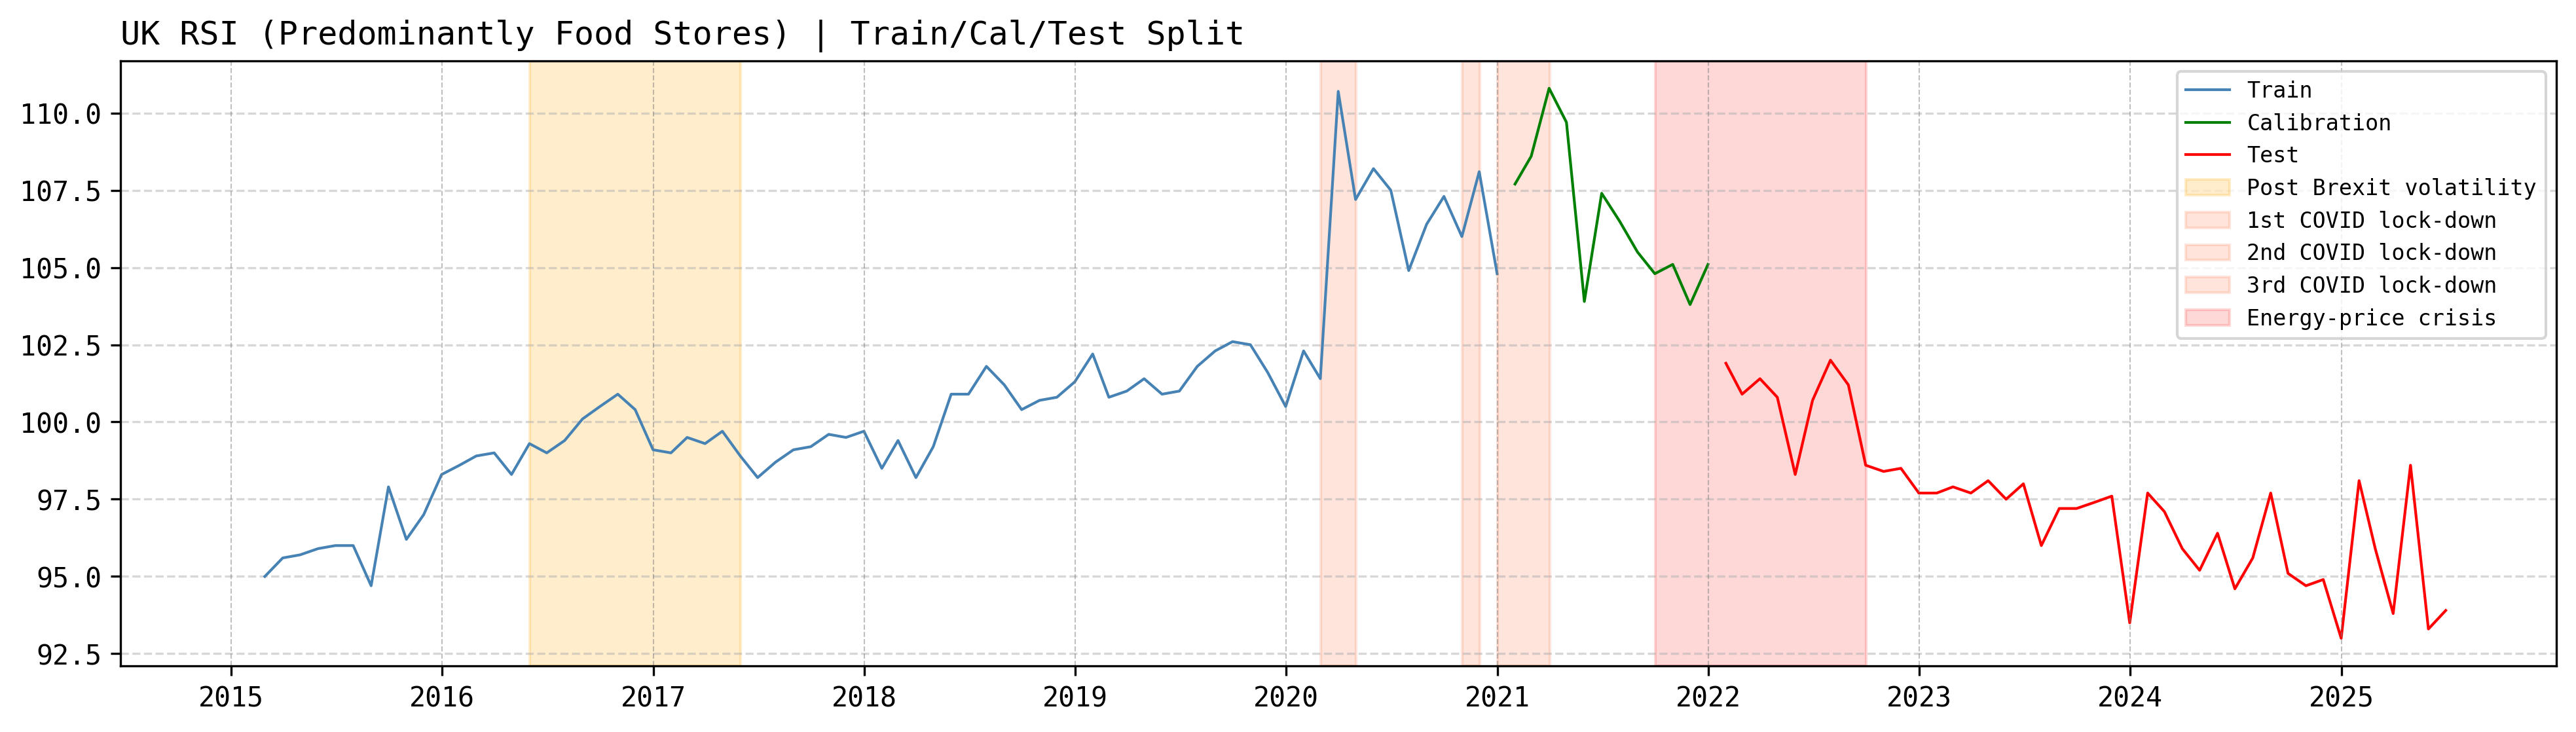

In [24]:
# TTS visualization
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(x=y_train.index, y=y_train, linewidth=1, color='steelblue', label='Train')
ax = sns.lineplot(x=y_cal.index, y=y_cal, linewidth=1, color='green', label='Calibration')
ax = sns.lineplot(x=y_test.index, y=y_test, linewidth=1, color='red', label='Test')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores) | Train/Cal/Test Split', loc='left')
plt.show()